In [1]:
import os
import sys
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage
from langchain.agents.agent_types import AgentType

import functools
import operator
from typing import List, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

import pandas as pd

sys.path.append("/mnt/c/Projects/my-assistant")
from pipelines.stock_buddy.utils import get_current_datetime

# from pipelines.stock_buddy.functions.finance import balance_sheet#, income_statement, cash_flow, ratio 

USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/nguyenph/miniconda3/envs/pipeline/lib/python3.11/site-packages/langgraph/graph/graph.py:36: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.pregel import Channel, Pregel


### Helper utils

In [2]:


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Define Agent

In [3]:


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o-mini")

tavily_tool = TavilySearchResults(max_results=3)


current_datetime_agent = create_react_agent(llm, tools=[get_current_datetime], 
                                            state_modifier="Your task is to provide the time context for the conversation, you don't need to answer. \
                                                You only use the function get_current_datetime if user mentions a relative time \
                                                    like 'now', 'today', 'yesterday', 'tomorrow', 'etc'. \
                                                        Your answer must follow the format: 'The current date and time is current_date_time'.")
current_datetime_node = functools.partial(agent_node, agent=current_datetime_agent, name="CurrentDateTime")

check_stock_code_agent = create_react_agent(llm, tools=[tavily_tool], 
                                            state_modifier="Your task is to provide the ticker symbol to the context for the conversation if there is only company name and no ticker symbol in the conversation,  \
                                                        Your answer must follow the format: 'The ticker symbol of XXXXXXX is YYY'.")
check_stock_code_node = functools.partial(agent_node, agent=check_stock_code_agent, name="TickerSymbol")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  CurrentDateTime, TickerSymbol. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "If there is already a stock code in the conversation, the TickerSymbol worker should not be called (The stock code normally is a uppercase string with 3 characters).",
    ["CurrentDateTime", "TickerSymbol"],
)

In [4]:
preprocess_graph = StateGraph(ResearchTeamState)
preprocess_graph.add_node("CurrentDateTime", current_datetime_node)
preprocess_graph.add_node("TickerSymbol", check_stock_code_node)
preprocess_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
preprocess_graph.add_edge("CurrentDateTime", "supervisor")
preprocess_graph.add_edge("TickerSymbol", "supervisor")
preprocess_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"CurrentDateTime": "CurrentDateTime", "TickerSymbol": "TickerSymbol", "FINISH": END},
)


preprocess_graph.add_edge(START, "supervisor")
chain = preprocess_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


preprocess_chain = enter_chain | chain

### Finance team

In [5]:
from vnstock3 import Vnstock
from pandas import DataFrame
from typing import Literal, Optional, Annotated, List, Tuple
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain_core.documents import Document

@tool
def balance_sheet(state: Annotated[dict, InjectedState],
                  symbol: str,
                  period: Optional[Literal["year", "quarter"]] = "year", 
                  lang: Optional[Literal["en", "vi"]] = "vi", 
                  source: Optional[Literal["VCI", "TCBS"]] = "VCI",
                  drop_na: Optional[Literal[True, False]] = True) -> str:
    """
    This function returns the balance sheet of a company by its symbol.
    
    Args:
        state (dict): The state of the conversation.
        symbol (str): The symbol of the company.
        period (str): The period of the balance sheet. It can be "year" or "quarter". Default is "year".
        lang (str): The language of the data. It can be "en" or "vi". Default is "vi".
        source(str): The source of the data. Default is "VCI". Currently, only "VCI" and "TCBS" are supported.
        dropna (bool): Whether to drop columns with all 0 values. Default is True.
    
    Returns:
        str: The balance sheet of the company.
    
    """
    if source == "VCI":
        stock = Vnstock().stock(symbol=symbol, source=source)
        df = stock.finance.balance_sheet(period=period, lang=lang, drop_na=drop_na)
        if df is not None and not df.empty:
            return df
    
    stock = Vnstock().stock(symbol=symbol, source="TCBS")
    df = stock.finance.balance_sheet(period=period, lang=lang)
    print(f"Balance sheet: {df}")
    
    agent = create_pandas_dataframe_agent(
        ChatOpenAI(temperature=0.1, model="gpt-4o-mini"),
        df,
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True
    )
    
    answer = agent.invoke(state['messages'][-1].content)
    print(f"Answer: {answer} ------ function: balance_sheet")
    return answer


In [6]:

# Document writing team graph state
class StockAgentState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This is the dataframe that the dataframe worker will use
    df: pd.DataFrame



llm = ChatOpenAI(model="gpt-4o-mini")

tavily_tool = TavilySearchResults(max_results=3)

current_datetime_agent = create_react_agent(llm, tools=[get_current_datetime], 
                                            state_modifier="Your task is to provide the time context for the conversation, you don't need to answer. \
                                                You only use the function get_current_datetime if user mentions a relative time \
                                                    like 'now', 'today', 'yesterday', 'tomorrow', 'etc'. \
                                                        Your answer must follow the format: 'The current date and time is current_date_time'.")
current_datetime_node = functools.partial(agent_node, agent=current_datetime_agent, name="CurrentDateTime")

check_stock_code_agent = create_react_agent(llm, tools=[tavily_tool], 
                                            state_modifier="Your task is to provide the ticker symbol to the context for the conversation if there is only company name and no ticker symbol in the conversation,  \
                                                        Your answer must follow the format: 'The ticker symbol of XXXXXXX is YYY'.")
check_stock_code_node = functools.partial(agent_node, agent=check_stock_code_agent, name="TickerSymbol")


finace_agent = create_react_agent(llm,tools=[balance_sheet])
finance_node = functools.partial(
    agent_node, agent=finace_agent, name="FinanceAgent"
)



supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["CurrentDateTime", "TickerSymbol", "FinanceAgent"],
)

### Create graph

In [15]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
graph = StateGraph(StockAgentState)
graph.add_node("CurrentDateTime", current_datetime_node)
graph.add_node("TickerSymbol", check_stock_code_node)
graph.add_node("FinanceAgent", finance_node)
graph.add_node("supervisor", supervisor)

# Add the edges that always occur
graph.add_edge("CurrentDateTime", "supervisor")
graph.add_edge("TickerSymbol", "supervisor")
graph.add_edge("FinanceAgent", "supervisor")

# Add the edges where routing applies
graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "CurrentDateTime": "CurrentDateTime",
        "TickerSymbol": "TickerSymbol",
        "FinanceAgent": "FinanceAgent",
        "FINISH": END,
    },
)

graph.add_edge(START, "supervisor")
chain = graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=graph.nodes)
    | graph.compile()
)

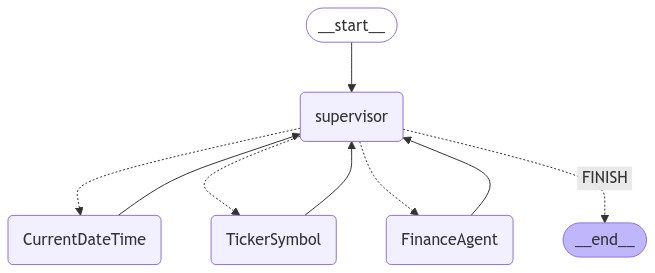

In [8]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [16]:
for s in authoring_chain.stream(
    "Cho tôi xem bảng cân đối kế toán của cổ phiếu TCB trong năm 2023.",
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'TickerSymbol'}}
---
{'TickerSymbol': {'messages': [HumanMessage(content='The ticker symbol of Techcombank is TCB.', additional_kwargs={}, response_metadata={}, name='TickerSymbol')]}}
---
{'supervisor': {'next': 'FinanceAgent'}}
---


2024-09-23 14:13:13,403 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-09-23 14:13:14,586 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-09-23 14:13:15,458 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-09-23 14:13:16,389 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


{'FinanceAgent': {'messages': [HumanMessage(content='Sorry, need more steps to process this request.', additional_kwargs={}, response_metadata={}, name='FinanceAgent')]}}
---
{'supervisor': {'next': 'CurrentDateTime'}}
---
{'CurrentDateTime': {'messages': [HumanMessage(content='Bạn có thể cho tôi biết bạn muốn xem thông tin về cổ phiếu TCB vào thời điểm nào không?', additional_kwargs={}, response_metadata={}, name='CurrentDateTime')]}}
---
{'supervisor': {'next': 'CurrentDateTime'}}
---
{'CurrentDateTime': {'messages': [HumanMessage(content='The current date and time is 2023-10-04T12:00:00.', additional_kwargs={}, response_metadata={}, name='CurrentDateTime')]}}
---
{'supervisor': {'next': 'FinanceAgent'}}
---


2024-09-23 14:13:22,869 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-09-23 14:13:23,807 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-09-23 14:13:24,788 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-09-23 14:13:25,738 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


{'FinanceAgent': {'messages': [HumanMessage(content='Sorry, need more steps to process this request.', additional_kwargs={}, response_metadata={}, name='FinanceAgent')]}}
---


GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.